# 3. Classification

---

### Setup

In [1]:
import sys
sys.path.insert(1, '../../utils')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ds_functions as ds
from sklearn.model_selection import StratifiedKFold

data: pd.DataFrame = pd.read_csv('original.csv', sep=';')
data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,False,582,False,20,True,265000.00,1.9,130,True,False,4,True
1,55.0,False,7861,False,38,False,263358.03,1.1,136,True,False,6,True
2,65.0,False,146,False,20,False,162000.00,1.3,129,True,True,7,True
3,50.0,True,111,False,20,False,210000.00,1.9,137,True,False,7,True
4,65.0,True,160,True,20,False,327000.00,2.7,116,False,False,8,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,False,61,True,38,True,155000.00,1.1,143,True,True,270,False
295,55.0,False,1820,False,38,False,270000.00,1.2,139,False,False,271,False
296,45.0,False,2060,True,60,False,742000.00,0.8,138,False,False,278,False
297,45.0,False,2413,False,38,False,140000.00,1.4,140,True,True,280,False


## 3.0. Training Models

---

### Training Models

---

#### StratifiedKFold function
After loading the data, in data dataframe, we need to separate the target variable which is the DEATH_EVENT from the rest of the data, since it plays a different role in the training procedure. Through the application of the pop method, we get the class variable, and simultaneously removing it from the dataframe. So, y will keep the ndarray with the target variable for each record and X the ndarray containing the records themselves

In [2]:
target = 'DEATH_EVENT'
positive = True
negative = False
values = {'Original': [len(data[data[target] == positive]), len(data[data[target] == negative])]}

y: np.ndarray = data.pop(target).values
X: np.ndarray = data.values
labels: np.ndarray = pd.unique(y)

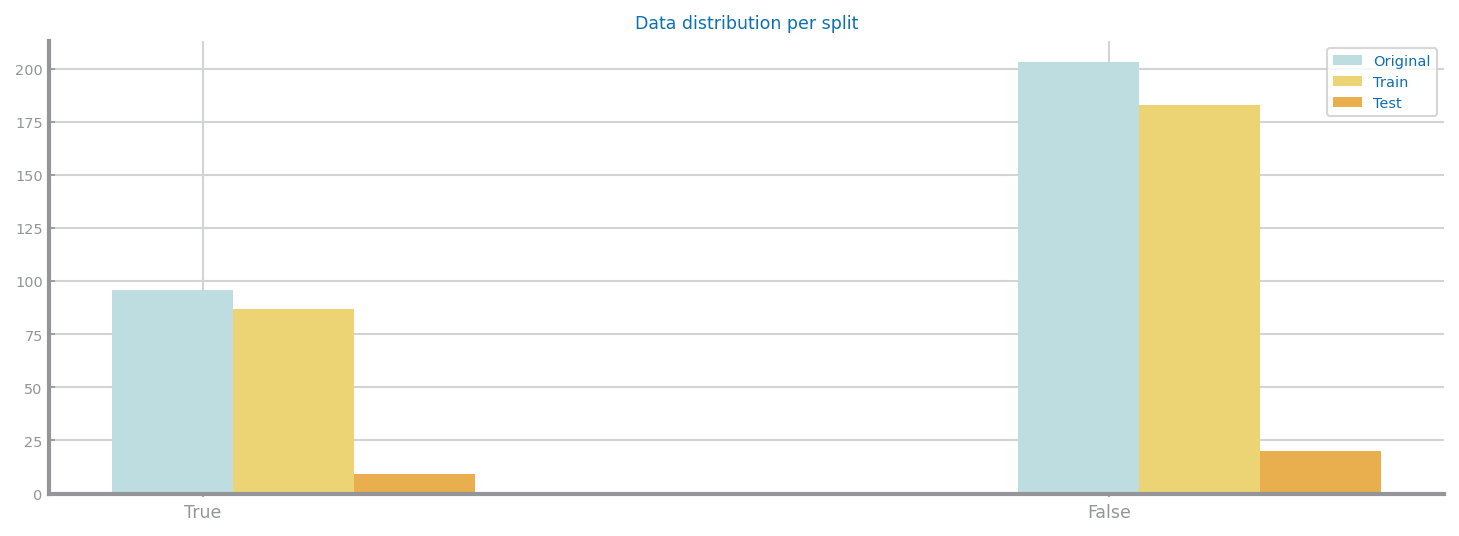

In [3]:
np.random.seed(1)
skf = StratifiedKFold(n_splits=10, shuffle=True)
skf.get_n_splits(X, y)

splits=[]

for train_index, test_index in skf.split(X, y):
    splits.append({'X_train': X[train_index], 'X_test': X[test_index],
                  'y_train': y[train_index], 'y_test': y[test_index]})

values['Train'] = [len(np.delete(y[train_index], np.argwhere(y[train_index]==negative))), len(np.delete(y[train_index], np.argwhere(y[train_index]==positive)))]
values['Test'] = [len(np.delete(y[test_index], np.argwhere(y[test_index]==negative))), len(np.delete(y[test_index], np.argwhere(y[test_index]==positive)))]

plt.figure(figsize=(12,4))
ds.multiple_bar_chart([positive, negative], values, title='Data distribution per split', showXTickLabels=True)
plt.show()

We have just plotted the chart of one split because the splits have identical distribution which will make the bar charts equal.

## 3.4. Random Forests
---

<Figure size 600x450 with 0 Axes>

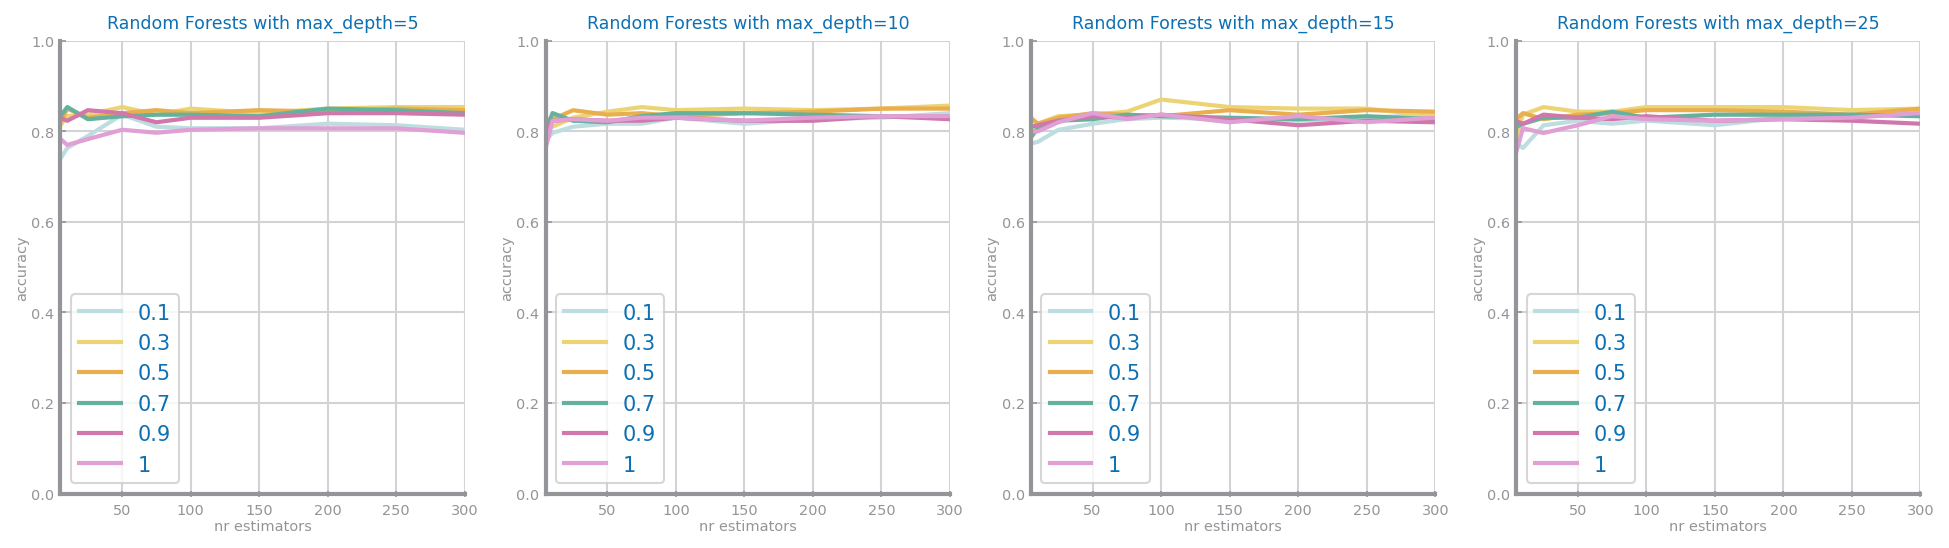

Best results with depth=10, 0.100000 features and 10 estimators, with accuracy=0.966667
Best results per split:
	Split 0: depth=10 , 1.000000 features and 10 estimators ==> accuracy=0.866667
	Split 1: depth=5 , 0.300000 features and 100 estimators ==> accuracy=0.833333
	Split 2: depth=5 , 0.700000 features and 10 estimators ==> accuracy=0.900000
	Split 3: depth=10 , 0.500000 features and 25 estimators ==> accuracy=0.933333
	Split 4: depth=5 , 0.300000 features and 5 estimators ==> accuracy=0.933333
	Split 5: depth=10 , 0.300000 features and 200 estimators ==> accuracy=0.933333
	Split 6: depth=5 , 0.100000 features and 50 estimators ==> accuracy=0.866667
	Split 7: depth=5 , 0.100000 features and 25 estimators ==> accuracy=0.900000
	Split 8: depth=10 , 0.100000 features and 10 estimators ==> accuracy=0.966667
	Split 9: depth=5 , 0.300000 features and 10 estimators ==> accuracy=0.965517


In [4]:
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

n_estimators = [5, 10, 25, 50, 75, 100, 150, 200, 250, 300]
max_depths = [5, 10, 15, 25]
max_features = [.1, .3, .5, .7, .9, 1]
best = (0, 0, 0) #(depth, feature, estimators) 
last_best = 0
best_forest = None
best_split = None
best_spli = 0

NUM_SPLITS = len(splits)
split_best = [('',  0, 0.0)] * NUM_SPLITS
split_best_forest = [None] * NUM_SPLITS
split_last_best = [0] * NUM_SPLITS

cols = len(max_depths)

plt.figure()
fig, axs = plt.subplots(1, cols, figsize=(cols*ds.HEIGHT, ds.HEIGHT), squeeze=False)

for k in range(len(max_depths)):
    d = max_depths[k]
    values = {}
    for f in max_features:
        values[f] = []
        for i in range(len(n_estimators)):
            values[f].append(0)
    for spli in range(NUM_SPLITS):
        split = splits[spli]
        for f in max_features:
            yvalues = []
            for n in n_estimators:
                rf = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
                rf.fit(split['X_train'], split['y_train'])
                split['prdY'] = rf.predict(split['X_test'])
                yvalues.append(metrics.accuracy_score(split['y_test'], split['prdY']))
                                               
                # Check if accuracy is better than best overall
                if yvalues[-1] > last_best:
                    best = (d, f, n)
                    last_best = yvalues[-1]
                    best_forest = rf
                    best_split = split
                    best_spli = spli
                                               
                # Check if accuracy is better than best in current split
                if yvalues[-1] > split_last_best[spli]:
                    split_best[spli] = (d, f, n)
                    split_last_best[spli] = yvalues[-1]
                    split_best_forest[spli] = rf
                                               
            # Increment total accuracy for current (max_depth, min_impurity decrease)
            for i in range(len(yvalues)):
                values[f][i] += yvalues[i]
    # Normalize
    for v in values:
        for i in range(len(values[v])):
            values[v][i] /= NUM_SPLITS
            
    ds.multiple_line_chart(n_estimators, values, ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
                           xlabel='nr estimators', ylabel='accuracy', percentage=True)
plt.show()
print('Best results with depth=%d, %f features and %d estimators, with accuracy=%f'%(best[0], best[1], best[2], last_best))

print('Best results per split:')
for i in range(len(splits)):
    print('\tSplit %d: depth=%d , %f features and %d estimators ==> accuracy=%f' % (i, *split_best[i], split_last_best[i]))

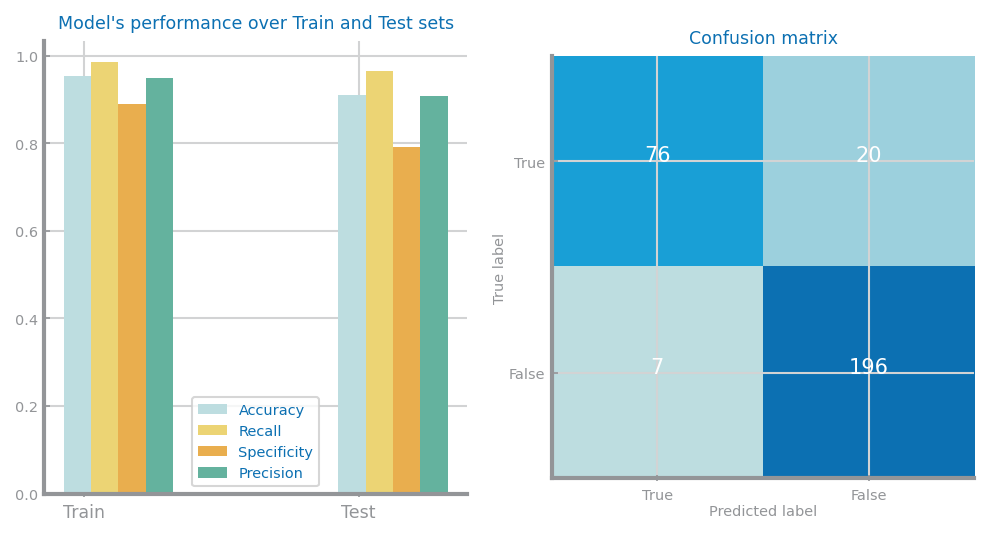

In [5]:
y_train_all = []
prd_train_all = []
y_test_all = []
prd_test_all = []

for i in range(NUM_SPLITS):
    y_train_all.extend(splits[i]['y_train'])
    prd_train_all.extend(split_best_forest[i].predict(splits[i]['X_train']))
    y_test_all.extend(splits[i]['y_test'])
    prd_test_all.extend(split_best_forest[i].predict(splits[i]['X_test']))

ds.plot_evaluation_results(labels, y_train_all, prd_train_all, y_test_all, prd_test_all, showXTickLabels=True)

In [6]:
mean = np.mean(split_last_best)
std = np.std(split_last_best)
confidences = (0.95, 0.99)
t_st = (1.812, 2.764)

print(f'Mean value: {round(mean, 3)}')

for c in range(len(confidences)):
    conf = confidences[c]
    minAcc = mean - t_st[c] * std / (10**0.5)
    maxAcc = mean + t_st[c] * std / (10**0.5)
    print(f'{int(conf*100)}% cofidence interval for accuracy: [' +
        f'{round(minAcc, 3)},{round(maxAcc, 3)}]')

Mean value: 0.91
95% cofidence interval for accuracy: [0.886,0.934]
99% cofidence interval for accuracy: [0.873,0.947]


### Overfitting study

<Figure size 600x450 with 0 Axes>

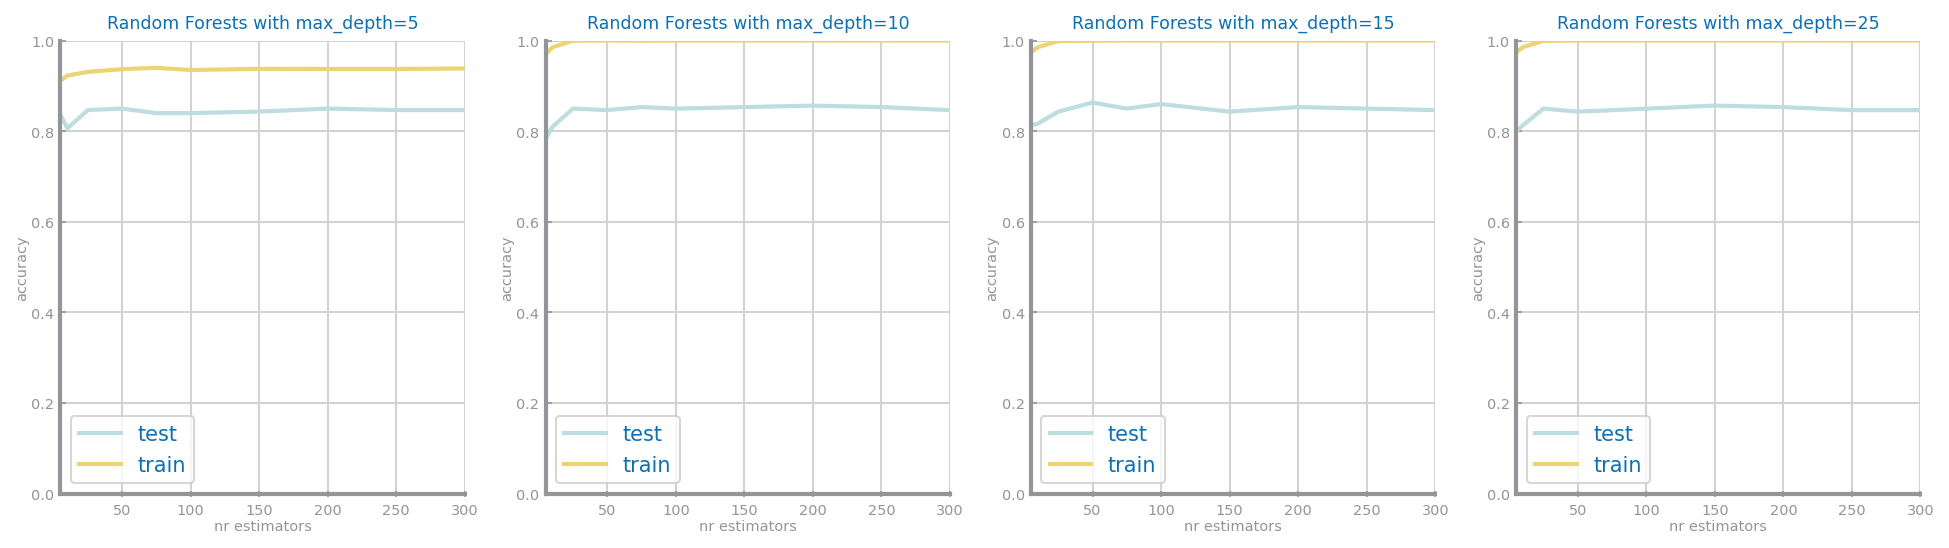

In [8]:
values = []

for k in range(len(max_depths)):
    values .append(
        {'test': [0 for _ in n_estimators], 
         'train': [0 for _ in n_estimators]})

for i in range(NUM_SPLITS):
    f = split_best[i][1]
    
    for k in range(len(max_depths)):
        d = max_depths[k]
        
        yvalues = []
        yvalues_train = []
        for n in n_estimators:
            forest = RandomForestClassifier(n_estimators=n, max_depth=d, max_features=f)
            forest.fit(splits[i]['X_train'], splits[i]['y_train'])
            prdY = forest.predict(splits[i]['X_test'])
            prdY_train = forest.predict(splits[i]['X_train'])
            yvalues.append(metrics.accuracy_score(splits[i]['y_test'], prdY))
            yvalues_train.append(metrics.accuracy_score(splits[i]['y_train'], prdY_train))
        values[k]['test'] = [values[k]['test'][v] + 
            yvalues[v]/NUM_SPLITS for v in range(len(yvalues))]
        values[k]['train'] = [values[k]['train'][v] +
            yvalues_train[v]/NUM_SPLITS for v in range(len(yvalues_train))]
        
plt.figure()
fig, axs = plt.subplots(1, len(max_depths), figsize=(16, 4), squeeze=False)
for k in range(len(max_depths)):
    d = max_depths[k]
    ds.multiple_line_chart(n_estimators, values[k], ax=axs[0, k], title='Random Forests with max_depth=%d'%d,
        xlabel='nr estimators', ylabel='accuracy', percentage=True)
plt.show()

### Summary
---

- ***How does performance changes with the number of estimators?***

Performance tends to stabilize as we increase the number of estimators.

- ***How does performance changes with the number of features?***

0.3 and 0.5 seem to have a little more performance overall, and 0.1 and 1 seem to be the worst in terms of performance for most cases.

- ***How do models improve with the increase of max_depth?***

The graphs seem to be more stable as we increase it even though normally the best performance is achieved with smaller max_depth.

- ***What is the best parametrisation (max_depth, number of estimators and features)?***

Best results with depth=5, 0.300000 features and 25 estimators, with accuracy=1.000000

- ***Is the accuracy achieved good enough?***

In most cases yes, always between 0.8 and 1.

- ***What is the largest kind of errors?***

False negatives.

- ***Is it possible to identify overfitting?***

Yes. We can observe that as we increase max_depth the accuracy in train set diverges from the one of the test set.
